In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import glob

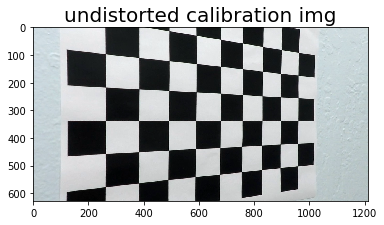

In [2]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners,ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

def undistort(img):
    h,  w = img.shape[:2]
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
    # undistort
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
    # crop the image
    x,y,w,h = roi
    return dst[y:y+h, x:x+w]

img = cv2.imread(images[3])
dst = undistort(img)
cv2.imwrite('output_images/calibresult.png',dst)
plt.imshow(dst)
plt.title("undistorted calibration img",fontsize=20)

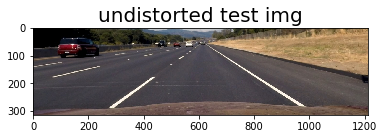

In [3]:
test_images = glob.glob('test_images/*.jpg')

img = cv2.imread(test_images[0])

def prepareIMG(img):
    dstfull = undistort(img)
    h,  w = dstfull.shape[:2]
    dst = dstfull[int(h/2):, :]
    return dst, dstfull,  h,  w

dst, dstfull, h_dst,  w_dst = prepareIMG(img)
cv2.imwrite('output_images/test_images1_undistort.png',dst)
dst_rgb = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(dst_rgb)
plt.title("undistorted test img",fontsize=20)

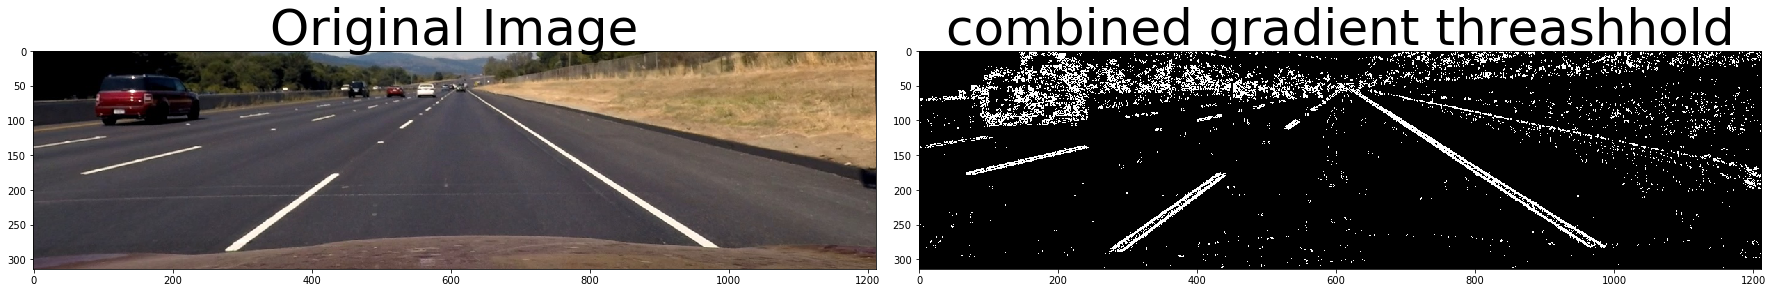

In [4]:
def sobel_thresh(gray, x_thr=(0,255), y_thr=(0,255), mag_thr=(0,255),  dir_thr=(0,np.pi/2), sob_kernel=3):
    #    return the S-channel of HLS
#     sCH = s_select(img, (20,255))
#     plt.figure(figsize=(10,40))
#     plt.imshow(sCH,  'gray')
#     rCH = r_select(img,(20,255))
#     plt.figure(figsize=(10,40))
#     plt.imshow(rCH,  'gray')
    
#     gray = (sCH+rCH)/2
#     plt.figure(figsize=(10,40))
#     plt.imshow(gray,  'gray')

    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sob_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sob_kernel)
#     grad_mag = np.sqrt(sobelx**2 + sobely**2)
    grad_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    absX = np.abs(sobelx)
    absY = np.abs(sobely)
    scaled_sobelx = np.uint8(255*absX/np.max(absX))
    scaled_sobely = np.uint8(255*absY/np.max(absY))
    binary_output_x = np.zeros_like(scaled_sobelx)
    binary_output_y = np.zeros_like(scaled_sobely)
    binary_output_x[(scaled_sobelx >= x_thr[0]) & (scaled_sobelx <= x_thr[1])] = 1
    binary_output_y[(scaled_sobely >= y_thr[0]) & (scaled_sobely <= y_thr[1])] = 1
    
#     grad_mag = (grad_mag/(np.max(grad_mag)/255)).astype(np.uint8) 
    binary_output_mag = np.zeros_like(grad_dir)
#     binary_output_mag[(grad_mag >= mag_thr[0]) & (grad_mag <= mag_thr[1])] = 1
    
    binary_output_dir =  np.zeros_like(grad_dir)
    binary_output_dir[(grad_dir >= dir_thr[0]) & (grad_dir <= dir_thr[1])] = 1
    
    
    return binary_output_x, binary_output_y, binary_output_mag, binary_output_dir



# Define a function that return the S-channel of HLS
def s_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_channel[(s_channel < thresh[0]) | (s_channel > thresh[1])] = 0
    return s_channel

def r_select(img, thresh=(0, 255)):
    r_channel = img[:,:,2]
    r_channel[(r_channel < thresh[0]) | (r_channel > thresh[1])] = 0
    return r_channel
    
def threashIMG(img):
    binary_output_x, binary_output_y, binary_output_mag, binary_output_dir =  \
        sobel_thresh(s_select(img, (20,255)), x_thr=(15,255), y_thr=(5,255), mag_thr=(200,255),  dir_thr=(np.pi/8,np.pi/2))
    combined1 = np.zeros_like(binary_output_x)
    combined1[(binary_output_x == 1) & (binary_output_y == 1) & (binary_output_dir == 1)] = 1
#     plt.figure(figsize=(10,40))
#     plt.imshow(combined1,  'gray')
    
    binary_output_x, binary_output_y, binary_output_mag, binary_output_dir =  \
        sobel_thresh(r_select(img, (20,255)), x_thr=(15,255), y_thr=(5,255), mag_thr=(200,255),  dir_thr=(np.pi/8,np.pi/2))
    combined2 = np.zeros_like(binary_output_x)
    combined2[(binary_output_x == 1) & (binary_output_y == 1) & (binary_output_dir == 1)] = 1
#     plt.figure(figsize=(10,40))
#     plt.imshow(combined2,  'gray')
    
    return combined1 | combined2

    
combined = threashIMG(dst)

cv2.imwrite('output_images/binary_threshHold.png',combined*255)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst_rgb)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined,'gray')
ax2.set_title('combined gradient threashhold', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


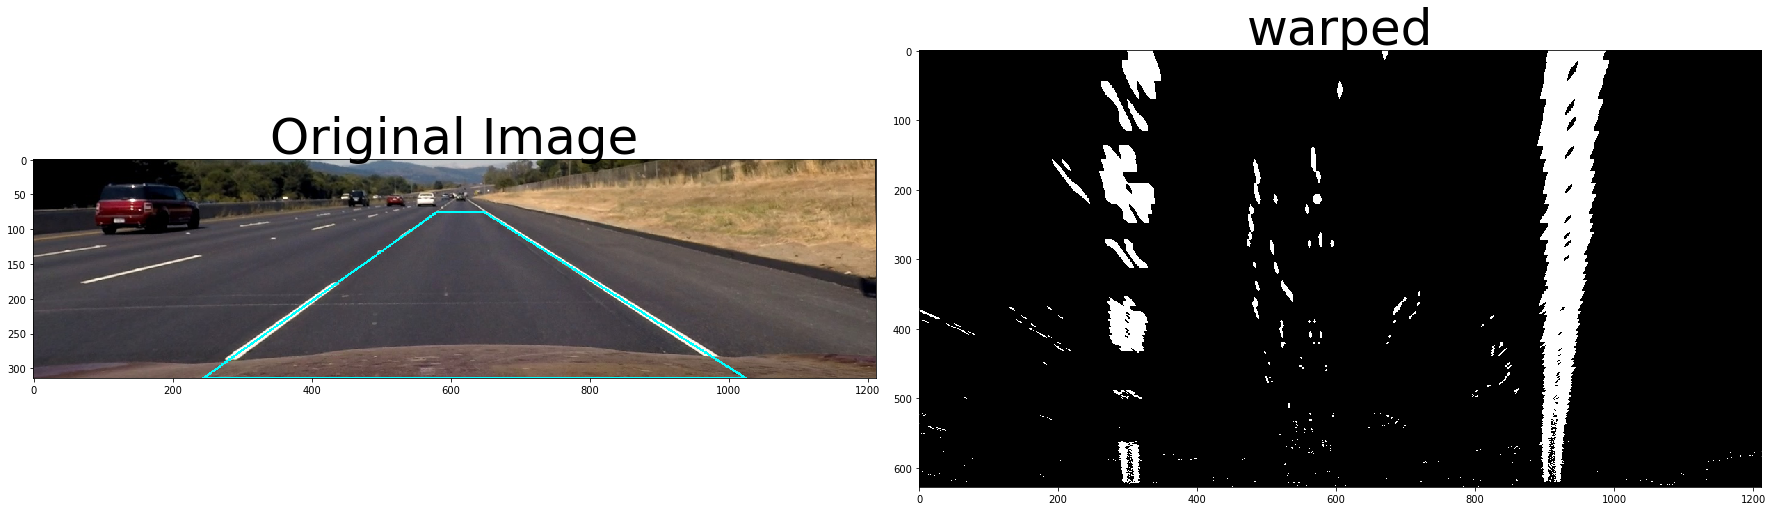

In [5]:
ratio = 2

img_size = dst.shape[:2][::-1]

srcP = np.float32(
    [[(img_size[0] / 2) - 25,  75],
    [((img_size[0] / 6) + 42), img_size[1]],
    [(img_size[0] * 5 / 6 + 15) , img_size[1]],
    [(img_size[0] / 2 + 41),  75]])
dstP = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]*ratio],
    [(img_size[0] * 3 / 4), img_size[1]*ratio],
    [(img_size[0] * 3 / 4), 0]])

dr = dst_rgb.astype(np.uint8)
cv2.polylines(dr,srcP.reshape((1,-1,2)).astype(np.int32) ,True,(0,255,255),thickness = 2,)


M = cv2.getPerspectiveTransform(srcP, dstP)
M_inv = cv2.getPerspectiveTransform(dstP, srcP)

def persTranIMG(img):
    return cv2.warpPerspective(img, M, (img_size[0], img_size[1] * ratio), flags=cv2.INTER_LINEAR)
    
warped = persTranIMG(combined)

cv2.imwrite('output_images/test_image_perspective.png',cv2.cvtColor(dr, cv2.COLOR_BGR2RGB))
cv2.imwrite('output_images/warped.png',warped*255)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dr)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped,'gray')
ax2.set_title('warped', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


True

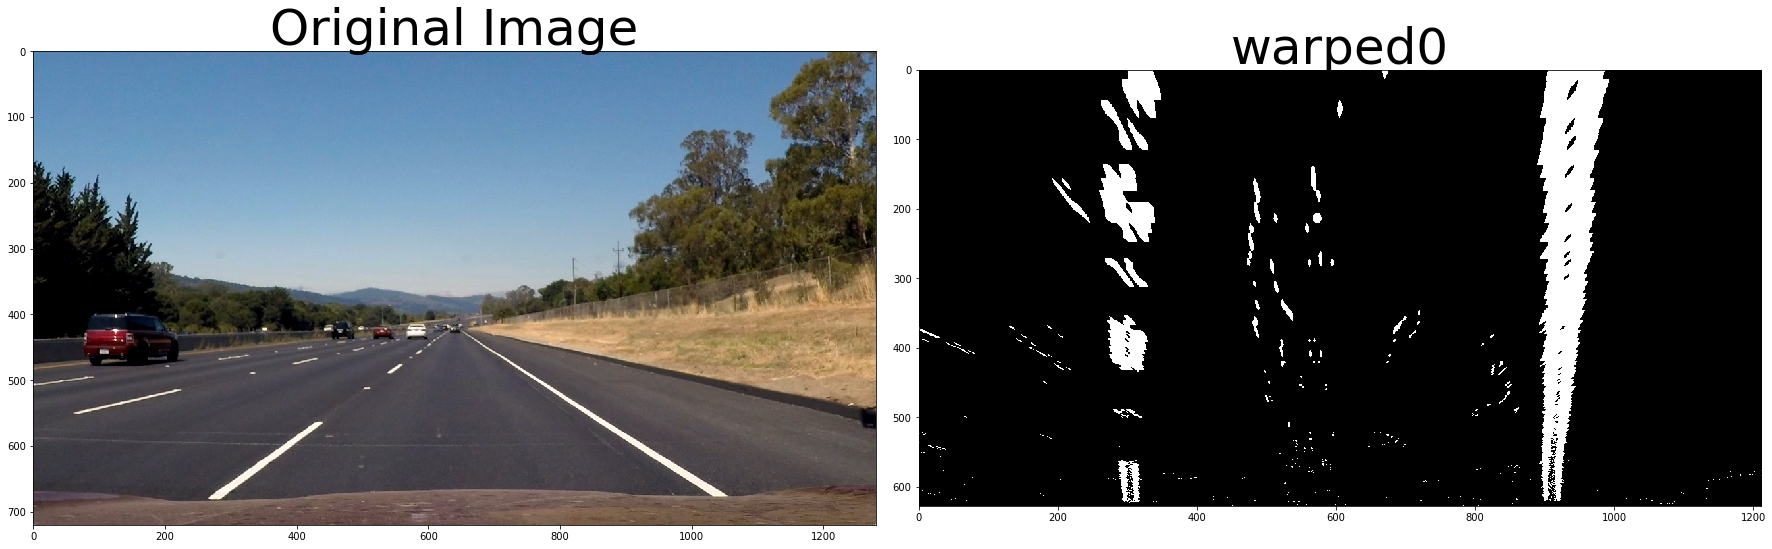

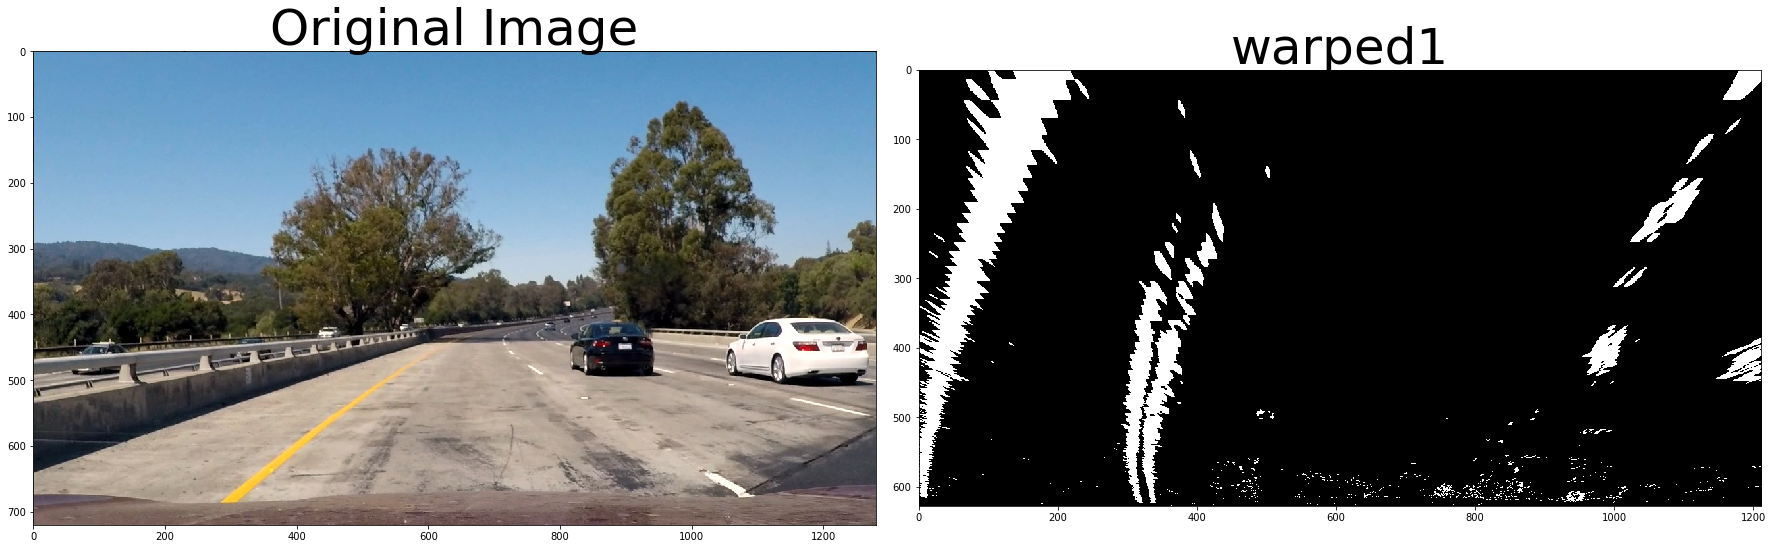

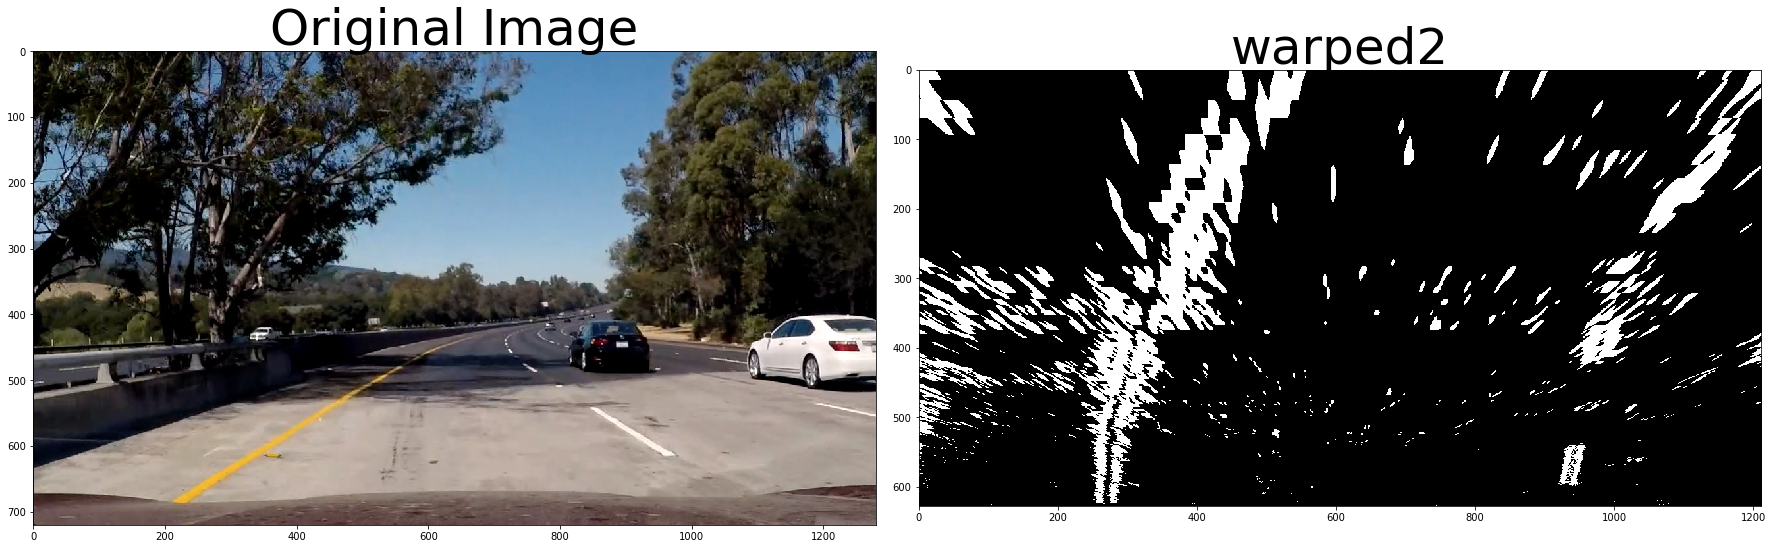

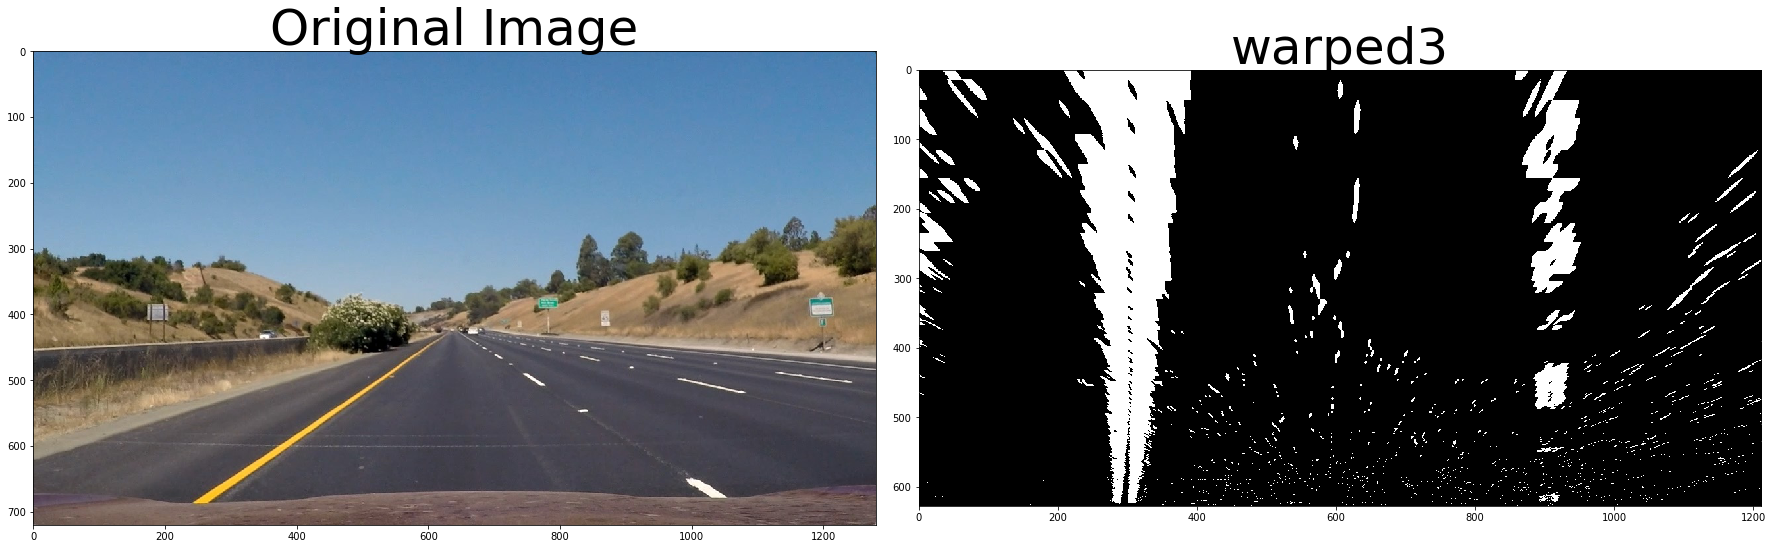

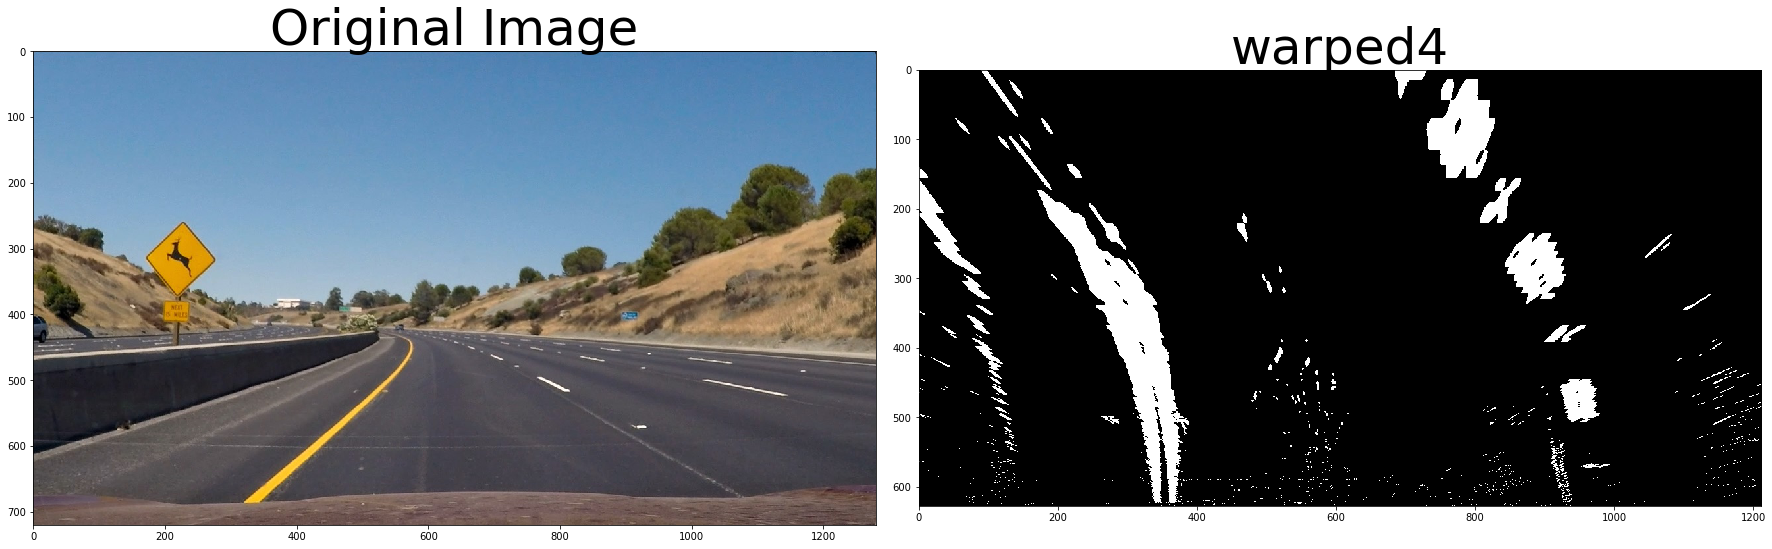

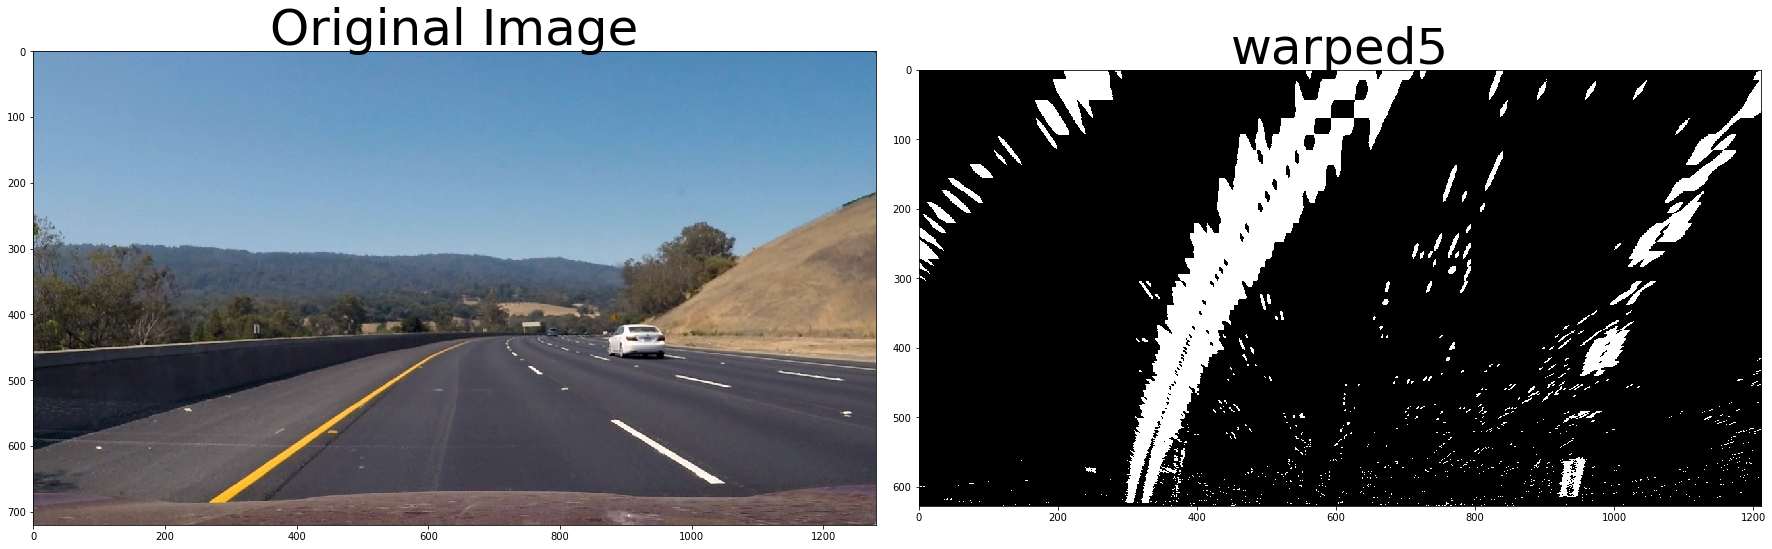

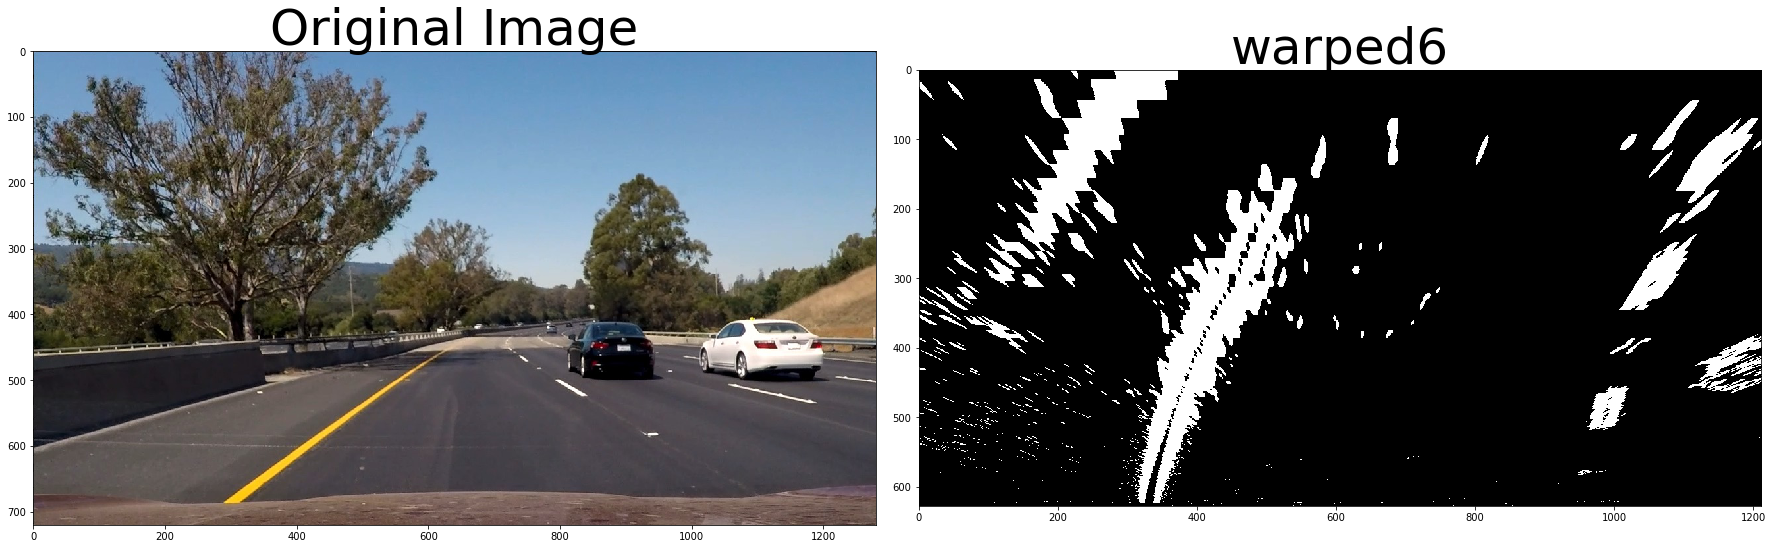

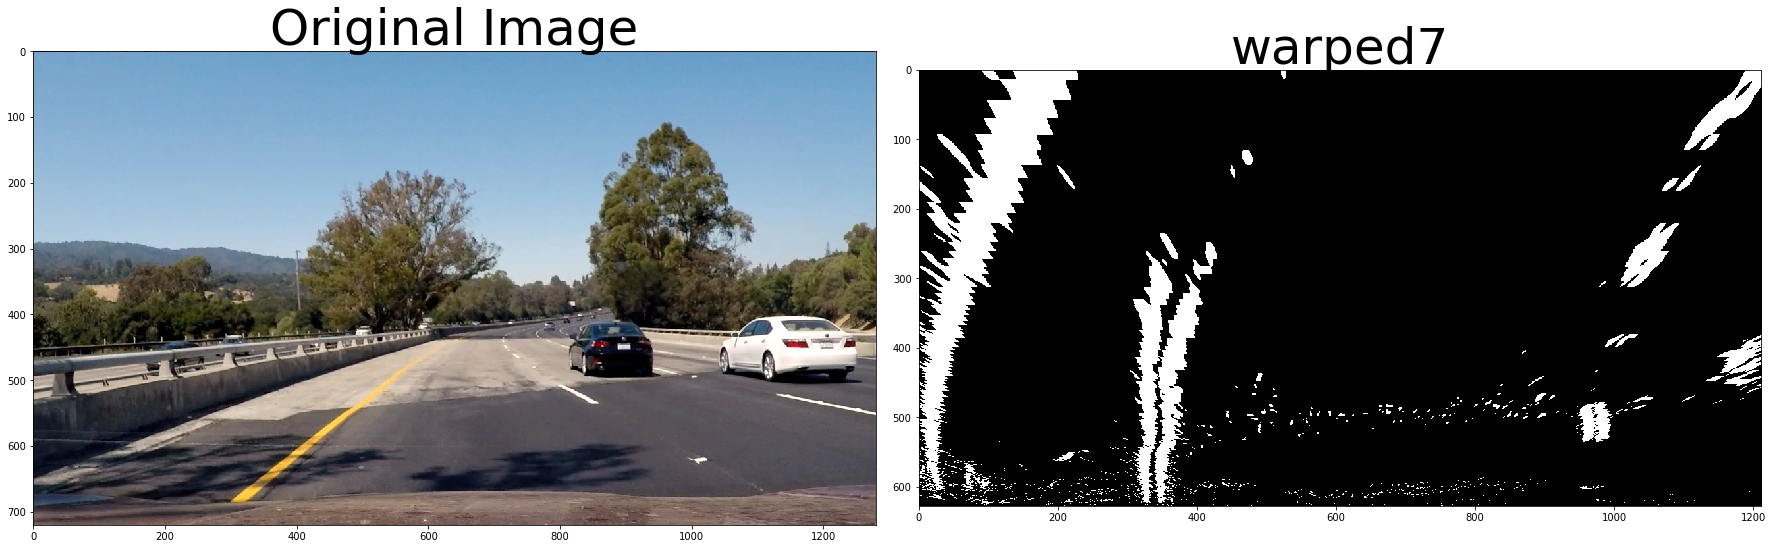

In [6]:
warpeds = []
i = 0
for test_image in test_images:
    img2 = cv2.imread(test_image)
    warped2 = persTranIMG(threashIMG(prepareIMG(img2)[0]))
    warpeds.append(warped2)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img2_rgb)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(warped2,'gray')
    ax2.set_title('warped' + str(i), fontsize=50)
    i+=1
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

cv2.imwrite('output_images/warped1.png',warpeds[1]*255)

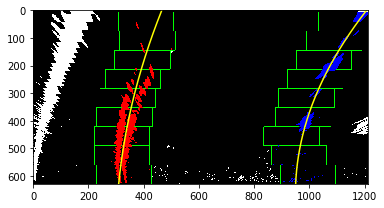

In [7]:
def fitPolyline_start(binary_warped, ifPlot = False):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        if ifPlot:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if ifPlot:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.figure()
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, w_dst)
        plt.ylim(h_dst, 0)
        plt.savefig('output_images/lane_start.png')
        
    return left_fit, right_fit
    

left_fit, right_fit = fitPolyline_start(warpeds[1], True)

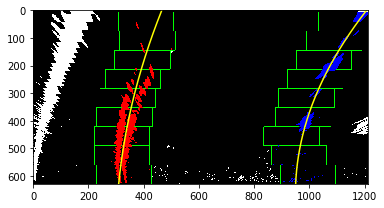

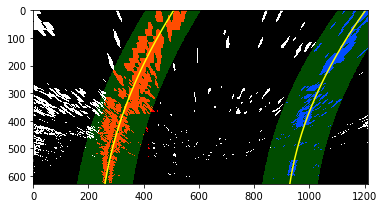

In [8]:
def fitPolyline_follow(binary_warped, left_fit, right_fit, ifPlot = False):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting

    if ifPlot:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.figure()
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, w_dst)
        plt.ylim(h_dst, 0)
        plt.savefig('output_images/lane_follow.png')
    return left_fit, right_fit, leftx, lefty, rightx, righty


left_fit, right_fit = fitPolyline_start(warpeds[1], True)
left_fit, right_fit, leftx, lefty, rightx, righty = fitPolyline_follow(warpeds[2], left_fit, right_fit, True)



In [9]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def calCurv(leftx, lefty, rightx, righty):
    ploty = np.linspace(0, h_dst-1, num=h_dst)# to cover same y-range as image
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters


    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

print (calCurv(leftx, lefty, rightx, righty))
    


(442.03062574965082, 364.05683574561453)


True

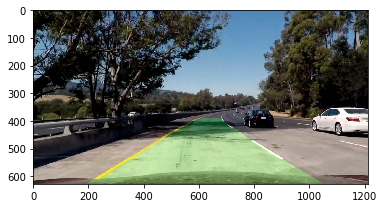

In [16]:
def drawLane(img, left_fit, right_fit):
    ploty = np.linspace(0, h_dst-1, num=120)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    lane = np.zeros_like(img)
#     print (img.shape)
    
    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    line_pts = np.hstack((left_line, right_line))
    cv2.fillPoly(lane, np.int_([line_pts]), (0,255, 0))
    laneTran = cv2.warpPerspective(lane, M_inv, (img_size[0], img_size[1] * ratio), flags=cv2.INTER_LINEAR)
    lane = cv2.addWeighted(img, 1, np.roll(laneTran, img_size[1], axis = 0), 0.2, 0)
    return lane
    
lane = drawLane(prepareIMG(cv2.imread(test_images[2]))[1], left_fit, right_fit)
plt.figure()
plt.imshow(cv2.cvtColor(lane, cv2.COLOR_BGR2RGB))
cv2.imwrite('output_images/lane_on_road.png',lane)
    
    
    

In [36]:
frame_diff = 30
frame_add_ratio = 0.15
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = 0 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def process_newfit(self):
        left_fit, right_fit = self.best_fit
        left_bottom = left_fit[0]*h_dst**2 + left_fit[1]*h_dst + left_fit[2]
        right_bottom = right_fit[0]*h_dst**2 + right_fit[1]*h_dst + right_fit[2]
        left_fit, right_fit = self.current_fit
        left_bottom_new = left_fit[0]*h_dst**2 + left_fit[1]*h_dst + left_fit[2]
        right_bottom_new = right_fit[0]*h_dst**2 + right_fit[1]*h_dst + right_fit[2]
        center_new = (left_bottom_new + right_bottom_new) / 2
        self.line_base_pos = (center_new - w_dst/2) * xm_per_pix
        if(abs(left_bottom - left_bottom_new) > frame_diff or
           abs(right_bottom - right_bottom_new) > frame_diff):
            self.detected = False 
            print('reset', str(left_bottom - left_bottom_new), str(right_bottom - right_bottom_new))
            return;
        self.best_fit = (1-frame_add_ratio)*self.best_fit + frame_add_ratio * self.current_fit
        self.detected = True
        

In [37]:
line = Line()


def process_image(image):
    #return should be a color image (3 channel) 

    dst, dstfull,  h,  w = prepareIMG(image)
    warped = persTranIMG(threashIMG(dst))
    
    if(line.detected == False):
        left_fit, right_fit = fitPolyline_start(warped)
        line.current_fit = np.array([left_fit, right_fit])
        line.best_fit = line.current_fit
        line.process_newfit()
    else:    
        left_fit, right_fit, leftx, lefty, rightx, righty = fitPolyline_follow(
            warped, line.best_fit[0], line.best_fit[1])
        line.current_fit = np.array([left_fit, right_fit])
        
        line.process_newfit()
        if(line.detected == True):
            left_curverad, right_curverad = calCurv(leftx, lefty, rightx, righty)
            line.radius_of_curvature = (1-frame_add_ratio)*line.radius_of_curvature\
                + frame_add_ratio *(left_curverad+right_curverad)/2
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(dstfull,'curvature radius' + "{:5.0f}".format(line.radius_of_curvature) + ' m, '
                    +"off center by {:5.2f}".format(line.line_base_pos) + ' m'
                    ,(10,100), font, 1,(255,255,255),2,cv2.LINE_AA)

    lane = drawLane(dstfull, line.best_fit[0], line.best_fit[1])
    return lane

In [38]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'project_video_out.mp4'

In [40]:
clip1 = VideoFileClip("project_video.mp4")#.subclip(21,24)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

reset -74.4341579394 -18.577671422
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


 44%|████▍     | 554/1261 [01:47<02:07,  5.53it/s]

reset 5.52431925057 34.5261338895


 46%|████▌     | 576/1261 [01:51<02:10,  5.23it/s]

reset 6.71659786012 -30.1000344822


 49%|████▉     | 618/1261 [01:59<02:08,  5.00it/s]

reset 7.18069220163 30.6027922557


 77%|███████▋  | 973/1261 [03:09<00:54,  5.33it/s]

reset -10.6634496516 -34.2628089938


 77%|███████▋  | 975/1261 [03:09<00:54,  5.21it/s]

reset -4.61979839708 -36.8700985622


 77%|███████▋  | 977/1261 [03:10<00:53,  5.32it/s]

reset 5.10191104505 -39.2176797109


 79%|███████▉  | 1001/1261 [03:14<00:47,  5.43it/s]

reset 19.2645746177 38.9504680387


100%|█████████▉| 1260/1261 [04:07<00:00,  5.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 8min 40s, sys: 2.1 s, total: 8min 42s
Wall time: 4min 8s


In [41]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))